In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import lfilter, firls, decimate
from tqdm import tqdm
from easydict import EasyDict as edict
from collections import Counter
import pickle
import rpy2.robjects as robj

%matplotlib inline

### Parameters

In [3]:
kappa = 1.53
lamb = 1e-6
r = 6
Lmin = 10
fct = 2
nsim = 50

In [4]:
robj.r["load"](f"/home/huaqingj/MyResearch/TVDN/NeuroImgR1/data/dataMat_Nsim{nsim}_Chg3_rank{r}_len180.RData")

'datamatrix','truematrix','candlist0','U'


In [ ]:
DetObjs = []
for i in tqdm(range(len(robj.r["datamatrix"]))):
    Ymat = np.array(robj.r["datamatrix"][i])
    DetRec = TVDNDetect(Ymat=Ymat, dataType="fMRI", MaxM=10, is_detrend=False,
                      saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=kappa, r=r, fct=fct)
    DetRec()
    DetObjs.append(DetRec)

In [115]:
# save the raw results
with open(f"./results/newSimu_fct{fct*10:.0f}_rank{r:.0f}_nsim{nsim}_raw.pkl", "wb") as f:
    pickle.dump(DetObjs, f)

In [5]:
with open(f"./results/newSimu_fct{fct*10:.0f}_rank{r:.0f}_nsim{nsim}_raw.pkl", "rb") as f:
    DetObjs = pickle.load(f)

## Results 

In [6]:
d, n = DetObjs[0].Ymat.shape
cpts =  np.array(robj.r["candlist0"])[1:-1]
cpts = cpts.astype(int)

### Plots under the true number of change points

In [7]:
ecptss = [DetObj.finalRes.chgMat[len(cpts)-1, :len(cpts)] for DetObj in DetObjs]

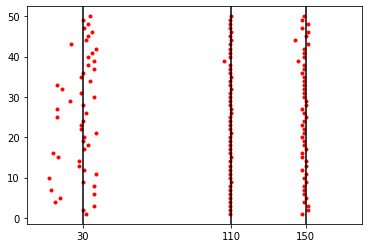

In [8]:
simuIdx = []
pos = []
for idx, chgpts in enumerate(ecptss):
    pos += list(chgpts)
    simuIdx += ([idx+1]*len(chgpts))
plt.plot(pos, simuIdx, ".", color="red")
plt.xlim([0, n])
plt.xticks(cpts, cpts)
for cpt in cpts:
    plt.axvline(cpt, color="black")

### Tuning optimal kappa for each data

In [24]:
kps = np.linspace(1.45, 2.0, 100)
numchgss = []
ecptss2 = []
for DetObj in DetObjs:
    DetObj.TuningKappa(kps)
    DetObj.UpdateEcpts()
    ecptss2.append(DetObj.ecpts)

In [25]:
numCpts = np.array([len(ecpts) for ecpts in ecptss2])
cRate = np.mean(numCpts == 3)
print(f"The rate is {cRate*100:.1f}%.")

The rate is 26.0%.


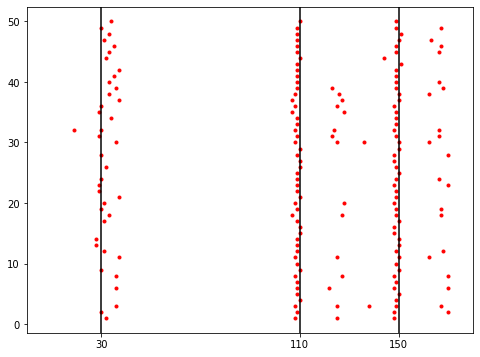

In [26]:
plt.figure(figsize=[8, 6])
simuIdx = []
pos = []
for idx, chgpts in enumerate(ecptss2):
    pos += list(chgpts)
    simuIdx += ([idx+1]*len(chgpts))
plt.plot(pos, simuIdx, ".", color="red")
plt.xlim([0, n])
plt.xticks(cpts, cpts)
for cpt in cpts:
    plt.axvline(cpt, color="black")

### Find the optimal kappa and get the plot under this kappa

In [116]:
kps = np.linspace(0, 4, 100)
numchgss = []
for DetObj in DetObjs:
    DetObj.TuningKappa(kps)
    numchgs = DetObj.numchgs
    numchgss.append(numchgs)

In [117]:
nChgArr = np.array(numchgss)
optIdx = np.argmin(np.abs(nChgArr.mean(axis=0) - 3))
optKp = kps[optIdx]
for DetObj in DetObjs:
    DetObj.UpdateEcpts(DetObj.numchgs[optIdx])

In [118]:
with open(f"./results/newSimu_fct{fct*10:.0f}_rank{r:.0f}_nsim{nsim}.pkl", "wb") as f:
    pickle.dump(DetObjs, f)

In [9]:
with open(f"./results/newSimu_fct{fct*10:.0f}_rank{r:.0f}_nsim{nsim}.pkl", "rb") as f:
    DetObjs = pickle.load(f)

In [10]:
ecptss = [DetObj.ecpts for DetObj in DetObjs]

In [12]:
numCpts = np.array([len(ecpts) for ecpts in ecptss])
cRate = np.mean(numCpts == 3)
print(f"The rate is {cRate*100:.1f}%.")

The rate is 82.0%.


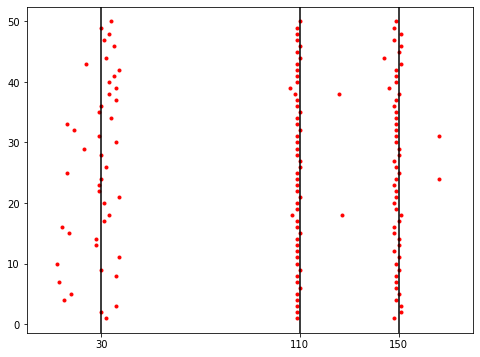

In [11]:
plt.figure(figsize=[8, 6])
simuIdx = []
pos = []
for idx, chgpts in enumerate(ecptss):
    pos += list(chgpts)
    simuIdx += ([idx+1]*len(chgpts))
plt.plot(pos, simuIdx, ".", color="red")
plt.xlim([0, n])
plt.xticks(cpts, cpts)
for cpt in cpts:
    plt.axvline(cpt, color="black")
plt.savefig(f"./plots/newSimu_cpts.jpg", bbox_inches='tight')

In [12]:
optKp = 1.575757576
print(f"The kappa is {optKp:.3f}")

The kappa is 1.576


### Reconstructed curve plot

In [13]:
trueXmat = np.array(robj.r["truematrix"][0]) # no error

In [14]:
RecXmats = []
MSEss = []
for idx, DetObj in enumerate(DetObjs):
    RecXmat = DetObj.RecResCur.EstXmatRealOrg
    MSEs = np.mean((trueXmat-RecXmat)**2, axis=1)#/np.sqrt(np.sum(trueXmat**2, axis=1))
    MSEss.append(MSEs)
    RecXmats.append(RecXmat)

In [15]:
MSEss = np.array(MSEss)
MSEssMean = np.mean(MSEss, axis=0)

In [16]:
# Find the index of 0, 25% 50% 75% and 100% quantile
MSEssQs = np.quantile(MSEssMean, [0, 0.25, 0.50, 0.75, 1], interpolation="nearest")
TmpMat = MSEssMean.reshape(1, -1) - MSEssQs.reshape(-1, 1)
plotIdxs = np.argmin(np.abs(TmpMat), axis=1)

In [17]:
RecXmats = np.array(RecXmats)
estMean = RecXmats.mean(axis=0)
estMedian = np.median(RecXmats, axis=0)
estLower = np.quantile(RecXmats, 0.025, axis=0)
estUpper = np.quantile(RecXmats, 1-0.025, axis=0)

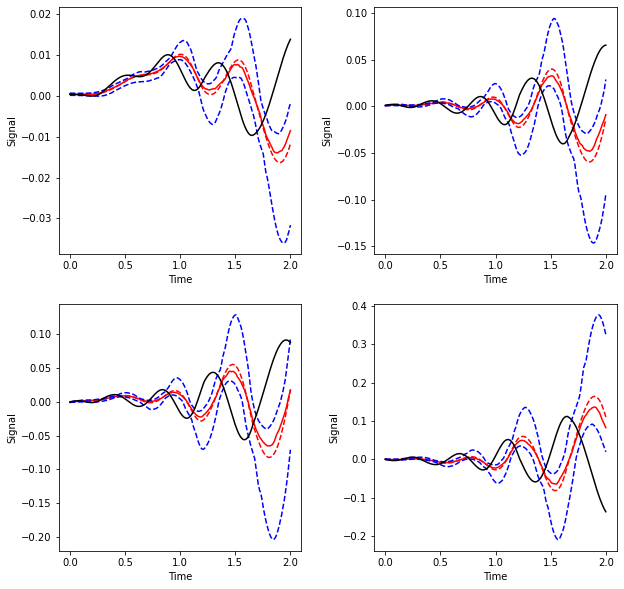

In [18]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0.3)
plt.subplot(2, 2, 1)
plt.ylabel("Signal")
plt.xlabel("Time")
plt.plot(DetObjs[0].time, estMean[plotIdxs[0], :], "--r")
plt.plot(DetObjs[0].time, estMedian[plotIdxs[0], :], "-r")
plt.plot(DetObjs[0].time, estLower[plotIdxs[0], :], "--b")
plt.plot(DetObjs[0].time, estUpper[plotIdxs[0], :], "--b")
plt.plot(DetObjs[0].time, trueXmat[plotIdxs[0], :], "-", color="black")

plt.subplot(2, 2, 2)
plt.ylabel("Signal")
plt.xlabel("Time")
plt.plot(DetObjs[0].time, estMean[plotIdxs[1], :], "--r")
plt.plot(DetObjs[0].time, estMedian[plotIdxs[1], :], "-r")
plt.plot(DetObjs[0].time, estLower[plotIdxs[1], :], "--b")
plt.plot(DetObjs[0].time, estUpper[plotIdxs[1], :], "--b")
plt.plot(DetObjs[0].time, trueXmat[plotIdxs[1], :], "-", color="black")

plt.subplot(2, 2, 3)
plt.ylabel("Signal")
plt.xlabel("Time")
plt.plot(DetObjs[0].time, estMean[plotIdxs[2], :], "--r")
plt.plot(DetObjs[0].time, estMedian[plotIdxs[2], :], "-r")
plt.plot(DetObjs[0].time, estLower[plotIdxs[2], :], "--b")
plt.plot(DetObjs[0].time, estUpper[plotIdxs[2], :], "--b")
plt.plot(DetObjs[0].time, trueXmat[plotIdxs[2], :], "-", color="black")

plt.subplot(2, 2, 4)
plt.ylabel("Signal")
plt.xlabel("Time")
plt.plot(DetObjs[0].time, estMean[plotIdxs[3], :], "--r")
plt.plot(DetObjs[0].time, estMedian[plotIdxs[3], :], "-r")
plt.plot(DetObjs[0].time, estLower[plotIdxs[3], :], "--b")
plt.plot(DetObjs[0].time, estUpper[plotIdxs[3], :], "--b")
plt.plot(DetObjs[0].time, trueXmat[plotIdxs[3], :], "-", color="black")

plt.savefig(f"./plots/newSimu_examples.jpg", bbox_inches='tight')

### Number of chgs vs BIC plot

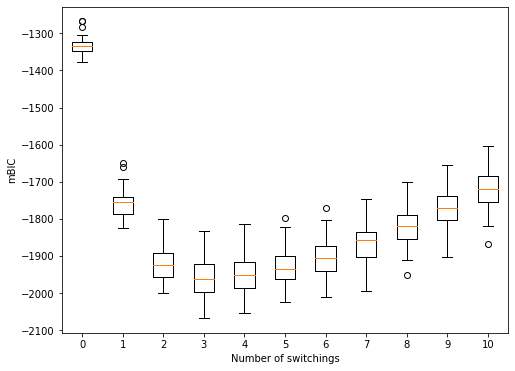

In [19]:
plt.figure(figsize=[8, 6])
mbicss = [DetObj.finalRes.U for DetObj in DetObjs]
mbicss = np.array(mbicss)
plt.boxplot(mbicss)
plt.xlabel("Number of switchings")
plt.ylabel("mBIC")
_ = plt.xticks(list(range(1, 12)), list(range(11)))
plt.savefig(f"./plots/newSimu_BIC_vs_nchgs.jpg", bbox_inches='tight')

### Ranks ve Error plot

In [20]:
DetObjss = edict()
DetObjss[f"rank{r}"] = DetObjs

In [34]:
for cR in [2, 4, 8, 10, 12, 14]:
    DetObjs = []
    for i in tqdm(range(len(robj.r["datamatrix"])), desc=f"Rank is {cR:.0f}"):
        Ymat = np.array(robj.r["datamatrix"][i])
        DetRec = TVDNDetect(Ymat=Ymat, dataType="fMRI", MaxM=10, is_detrend=False,
                          saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=optKp, r=cR, fct=fct)
        DetRec()
        DetObjs.append(DetRec)
        
    DetObjss[f"rank{cR:.0f}"] = DetObjs
    with open(f"./results/newSimu_fct{fct*10:.0f}_rank{cR:.0f}_nsim{nsim}.pkl", "wb") as f:
        pickle.dump(DetObjs, f)

Rank is 14: 100%|██████████| 50/50 [05:07<00:00,  5.97s/it]


In [21]:
for cR in [2, 4, 8, 10, 12, 14]:
    with open(f"./results/newSimu_fct{fct*10:.0f}_rank{cR:.0f}_nsim{nsim}.pkl", "rb") as f:
        DetObjs = pickle.load(f)
    DetObjss[f"rank{cR:.0f}"] = DetObjs

### Obtain the errors under each rank

In [22]:
Errss = []
Ranks = np.array([2, 4, 6, 8, 10, 12, 14])
for cR in Ranks:
    DetObjs = DetObjss[f"rank{cR:.0f}"]
    Errs = []
    for idx, DetObj in enumerate(DetObjs):
        RecXmat = DetObj.RecResCur.EstXmatRealOrg
        MSE = np.mean(np.mean((trueXmat-RecXmat)**2, axis=1))
        Errs.append(MSE)
    Errss.append(Errs)

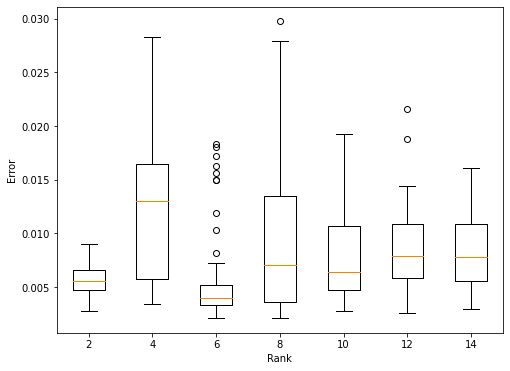

In [23]:
plt.figure(figsize=[8, 6])
ErrssArr = np.array(Errss).T
plt.boxplot(ErrssArr)
plt.xlabel("Rank")
plt.ylabel("Error")
_ = plt.xticks(list(range(1, 1+len(Ranks))), Ranks)
plt.savefig(f"./plots/newSimu_err_vs_rank.jpg", bbox_inches='tight')

In [24]:
np.median(ErrssArr,axis=0)

array([0.00557673, 0.01298268, 0.00396238, 0.00707447, 0.00642743,
       0.0078923 , 0.00784647])

## Varying number of knots for Bspline

In [25]:
nKnotss = [80, 100, 110, 130, 140, 160, 170]
#nKnotss = [60, 90, 120, 150, 180]

In [26]:
kappa = 1.576
lamb = 1e-6
r = 6
Lmin = 10
fct = 2

In [20]:
for nKnots in nKnotss:
    DetObjs = []
    for i in tqdm(range(len(robj.r["datamatrix"])), desc=f"The nKnots is {nKnots:.0f}"):
        Ymat = np.array(robj.r["datamatrix"][i])
        DetRec = TVDNDetect(Ymat=Ymat, dataType="fMRI", MaxM=10, is_detrend=False,
                          saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=kappa, r=r, fct=fct, nKnots=nKnots)
        DetRec()
        DetObjs.append(DetRec)
        
    with open(f"./results/newSimuKnots_nKnots{nKnots:.0f}_rank{r:.0f}_nsim{nsim}.pkl", "wb") as f:
        pickle.dump(DetObjs, f)

The nKnots is 170: 100%|██████████| 50/50 [03:07<00:00,  3.77s/it]


In [27]:
nKnotss = np.arange(80, 190, 10)
ErrsKnots = []
for nKnots in nKnotss:
    with open(f"./results/newSimuKnots_nKnots{nKnots:.0f}_rank{r:.0f}.pkl", "rb") as f:
        DetObjs = pickle.load(f)
    Errs = []
    for idx, DetObj in enumerate(DetObjs):
        RecXmat = DetObj.RecResCur.EstXmatRealOrg
        MSE = np.mean(np.mean((trueXmat-RecXmat)**2, axis=1))
        Errs.append(MSE)
    ErrsKnots.append(Errs)

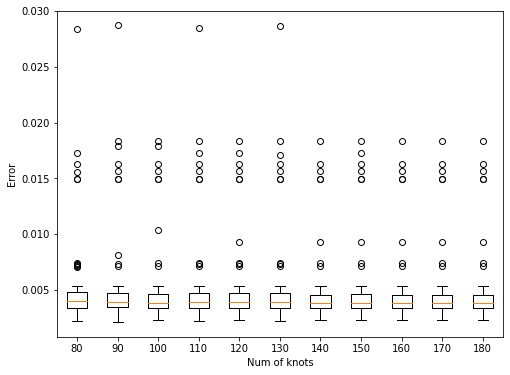

In [28]:
plt.figure(figsize=[8, 6])
ErrsKnotsArr = np.array(ErrsKnots).T
plt.boxplot(ErrsKnotsArr)
plt.xlabel("Num of knots")
plt.ylabel("Error")
_ = plt.xticks(list(range(1, 1+len(nKnotss))), nKnotss)
plt.savefig(f"./plots/newSimu_err_vs_nKnots.jpg", bbox_inches='tight')

In [29]:
ErrsKnotsArr.mean(axis=0)

array([0.00575407, 0.00595852, 0.00547802, 0.00589369, 0.00551613,
       0.00589963, 0.00517719, 0.00544346, 0.00517729, 0.00517739,
       0.00517666])